<a href="https://colab.research.google.com/github/aldabanushi/CVRPTW/blob/main/ProjectExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Objective Value is 2800949
Route 0: 19 Load(0) Time(0:00:00, 0:00:00) ->  Distance 0 km.
 27 Load(0) Time(8:42:42, 12:09:17) ->  Distance 119 km.
 31 Load(11) Time(16:25:45, 19:17:55) ->  Distance 122 km.
 47 Load(21) Time(18:27:33, 21:19:43) ->  Distance 133 km.
 38 Load(25) Time(19:01:24, 1 day, 0:00:00) ->  Distance 134 km.
 EndRoute 0. 

Route 1: 41 Load(0) Time(0:00:00, 0:00:00) ->  Distance 0 km.
 37 Load(0) Time(7:53:31, 8:06:35) ->  Distance 142 km.
 36 Load(4) Time(8:58:20, 9:11:24) ->  Distance 148 km.
 14 Load(6) Time(9:41:36, 9:54:40) ->  Distance 152 km.
 35 Load(15) Time(12:57:33, 13:10:37) ->  Distance 176 km.
 9 Load(26) Time(14:38:17, 14:51:21) ->  Distance 183 km.
 33 Load(35) Time(16:21:40, 16:34:44) ->  Distance 192 km.
 24 Load(41) Time(18:14:24, 20:01:20) ->  Distance 205 km.
 34 Load(55) Time(22:02:35, 1 day, 0:00:00) ->  Distance 230 km.
 EndRoute 1. 

Route 2: Empty 

Route 3: 18 Load(0) Time(0:00:00, 0:00:00) ->  Distance 0 km.
 39 Load(0) Time(0:35:38, 5:

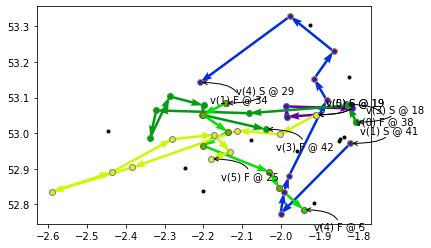

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from datetime import datetime, timedelta


class Customers():
   
    def __init__(self,
                 extents=None,
                 center=(53.381393, -1.474611),
                 block_size=10,
                 num_stops=100,
                 min_demand=0,
                 max_demand=25,
                 min_tw=1,
                 max_tw=5):
        self.number = num_stops  #: The number of customers and depots
        #: Location, a named tuple for locations.
        Location = namedtuple('Location', ['lat', 'lon'])
        if extents is not None:
            self.extents = extents  #: The lower left and upper right points
            #: Location[lat,lon]: the centre point of the area.
            self.center = Location(
                extents['urcrnrlat'] - 0.5 *
                (extents['urcrnrlat'] - extents['llcrnrlat']),
                extents['urcrnrlon'] - 0.5 *
                (extents['urcrnrlon'] - extents['llcrnrlon']))
        else:
            #: Location[lat,lon]: the centre point of the area.
            (clat, clon) = self.center = Location(center[0], center[1])
            rad_earth = 6367  # km
            circ_earth = np.pi * rad_earth
            #: The lower left and upper right points
            self.extents = {
                'llcrnrlon': (clon - 180 * block_size /
                              (circ_earth * np.cos(np.deg2rad(clat)))),
                'llcrnrlat':
                clat - 180 * block_size / circ_earth,
                'urcrnrlon': (clon + 180 * block_size /
                              (circ_earth * np.cos(np.deg2rad(clat)))),
                'urcrnrlat':
                clat + 180 * block_size / circ_earth
            }
        # The 'name' of the stop, indexed from 0 to num_stops-1
        stops = np.array(range(0, num_stops))
        # normaly distributed random distribution of stops within the block
        stdv = 6  # the number of standard deviations 
        lats = (self.extents['llcrnrlat'] + np.random.randn(num_stops) *
                (self.extents['urcrnrlat'] - self.extents['llcrnrlat']) / stdv)
        lons = (self.extents['llcrnrlon'] + np.random.randn(num_stops) *
                (self.extents['urcrnrlon'] - self.extents['llcrnrlon']) / stdv)
        # uniformly distributed integer demands.
        demands = np.random.randint(min_demand, max_demand, num_stops)

        self.time_horizon = 24 * 60**2  # A 24 hour period.

        # The customers demand min_tw to max_tw hour time window for each
        # delivery
        time_windows = np.random.randint(min_tw * 3600, max_tw * 3600,
                                                 num_stops)
        # The last time a delivery window can start
        latest_time = self.time_horizon - time_windows
        start_times = [None for o in time_windows]
        stop_times = [None for o in time_windows]
        # create random timedeltas, nominally from the start of the day.
        for index in range(self.number):
            stime = int(np.random.randint(0, latest_time[index]))
            start_times[index] = timedelta(seconds=stime)
            stop_times[index] = (
                start_times[index] + timedelta(seconds=int(time_windows[index])))
        # A named tuple for the customer
        Customer = namedtuple(
            'Customer',
            [
                'index',  # the index of the stop
                'demand',  # the demand for the stop
                'lat',  # the latitude of the stop
                'lon',  # the longitude of the stop
                'tw_open',  # timedelta window open
                'tw_close'
            ])  # timedelta window cls

        self.customers = [
            Customer(index, dem, lat, lon, tw_open, tw_close)
            for index, dem, lat, lon, tw_open, tw_close in zip(
                stops, demands, lats, lons, start_times, stop_times)
        ]

        # The number of seconds needed to 'unload' 1 unit of goods.
        self.service_time_per_dem = 300  # seconds
        self.time_stop_break=200

    def set_manager(self, manager):
        self.manager = manager

    def central_start_node(self, invert=False):
       
        num_nodes = len(self.customers)
        dist = np.empty((num_nodes, 1))
        for index_to in range(num_nodes):
            dist[index_to] = self._haversine(self.center.lon, self.center.lat,
                                           self.customers[index_to].lon,
                                           self.customers[index_to].lat)
        furthest = np.max(dist)

        if invert:
            prob = dist * 1.0 / sum(dist)
        else:
            prob = (furthest - dist * 1.0) / sum(furthest - dist)
        indexes = np.array([range(num_nodes)])
        start_node = np.random.choice(
            indexes.flatten(), size=1, replace=True, p=prob.flatten())
        return start_node[0]

    def create_distance_matrix(self, method='haversine'):
        
        self.distmat = np.zeros((self.number, self.number))
        methods = {'haversine': self._haversine}
        assert (method in methods)
        for frm_index in range(self.number):
            for to_index in range(self.number):
                if frm_index != to_index:
                    frm_c = self.customers[frm_index]
                    to_c = self.customers[to_index]
                    self.distmat[frm_index, to_index] = self._haversine(
                        frm_c.lon, frm_c.lat, to_c.lon, to_c.lat)
        return (self.distmat)

    def _haversine(self, lon1, lat1, lon2, lat2):
       
        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (np.sin(dlat / 2)**2 +
             np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2)
        c = 2 * np.arcsin(np.sqrt(a))

        # 6367 km is the radius of the Earth
        km = 6367 * c
        return km

    def get_total_demand(self):
        
        return (sum([c.demand for c in self.customers]))

    def return_dist_callback(self, **arbit):
        
        self.create_distance_matrix(**arbit)

        def dist_return(from_index, to_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = self.manager.IndexToNode(from_index)
            to_node = self.manager.IndexToNode(to_index)
            return (self.distmat[from_node][to_node])

        return dist_return

    def return_dem_callback(self):
        
        def dem_return(from_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = self.manager.IndexToNode(from_index)
            return (self.customers[from_node].demand)

        return dem_return

    def zero_depot_demands(self, depot):
        
        start_depot = self.customers[depot]
        self.customers[depot] = start_depot._replace(
            demand=0, tw_open=None, tw_close=None)

    def create_service_time_call_callback(self):
      
        def service_time_return(a, b):
            return (self.customers[a].demand * self.service_time_per_dem)

        return service_time_return


    def create_stop_time_call_callback(self):
      
        def stop_time_return(a, b):
            return  self.time_stop_break

        return stop_time_return
   

    def create_transit_time_callback(self, speed_kmph=10):
       
        def transit_time_return(a, b):
            return (self.distmat[a][b] / (speed_kmph * 1.0 / 60**2))

        return transit_time_return


class Vehicles():
  
    def __init__(self, capacity=100, cost=100, max_distance=100, number=None):

        Vehicle = namedtuple('Vehicle', ['index', 'capacity', 'cost', 'max_distance'])

        if number is None:
            self.number = np.size(capacity)
        else:
            self.number = number
        indexs = np.array(range(0, self.number))

        if np.isscalar(capacity):
            capacities = capacity * np.ones_like(indexs)
        elif np.size(capacity) != self.number:
            print('capacity is neither scalar, nor equal size to num!')
        else:
            capacities = capacity

        if np.isscalar(cost):
            costs = cost * np.ones_like(indexs)
        elif np.size(cost) != self.number:
            print(np.size(cost))
            print('cost is neither scalar, nor equal size to num!')
        else:
            costs = cost
   
        if np.isscalar(max_distance):
          max_distances = max_distance * np.ones_like(indexs)
        elif np.size(max_distance) != self.number:
            print('Max_distance is neither scalar, nor the same size as num!')
        else:
            max_distances = max_distance

        self.vehicles = [
            Vehicle(index, capacity, cost, max_distance)
            for (index, capacity, cost, max_distance) in zip(indexs, capacities, costs, max_distances)
        ]

    def get_total_capacity(self):
        return (sum([c.capacity for c in self.vehicles]))

    def return_starting_callback(self, customers, sameStartFinish=False):
        # create a different starting and finishing depot for each vehicle
        self.starts = [
            int(customers.central_start_node()) for o in range(self.number)
        ]
        if sameStartFinish:
            self.ends = self.starts
        else:
            self.ends = [
                int(customers.central_start_node(invert=True))
                for o in range(self.number)
            ]
        # the depots will not have demands, so zero them.
        for depot in self.starts:
            customers.zero_depot_demands(depot)
        for depot in self.ends:
            customers.zero_depot_demands(depot)

        def start_return(v):
            return (self.starts[v])

        return start_return


def discrete_cmap(N, base_cmap=None):
   #color map

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def vehicle_output_string(manager, routing, plan):
    
    dropped = []
    total_distance=0
    for order in range(routing.Size()):
        if (plan.Value(routing.NextVar(order)) == order):
            dropped.append(str(order))

    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    time_dimension = routing.GetDimensionOrDie('Time')
    plan_output = ''

    for route_number in range(routing.vehicles()):
        order = routing.Start(route_number)
        plan_output += 'Route {0}:'.format(route_number)
        distance=0
        if routing.IsEnd(plan.Value(routing.NextVar(order))):
            plan_output += ' Empty \n'
        else:
            while True:

                load_var = capacity_dimension.CumulVar(order)
                time_var = time_dimension.CumulVar(order)
                node = manager.IndexToNode(order)  
               
                plan_output += \
                    ' {node} Load({load}) Time({tmin}, {tmax}) -> '.format(
                        node=node,
                        load=plan.Value(load_var),
                        tmin=str(timedelta(seconds=plan.Min(time_var))),
                        tmax=str(timedelta(seconds=plan.Max(time_var))))
                previous_index = order    
                plan_output += ' Distance {0} km.\n'.format(distance)

                if routing.IsEnd(order):

                    plan_output += ' EndRoute {0}. \n'.format(route_number)

                    break
                order = plan.Value(routing.NextVar(order))   
                distance += routing.GetArcCostForVehicle(previous_index, order,route_number)
          
        plan_output += '\n'
        total_distance+=distance


    return (plan_output, dropped,total_distance)


def build_vehicle_route(manager, routing, plan, customers, veh_number):
   
    veh_used = routing.IsVehicleUsed(plan, veh_number)
    print('Vehicle {0} is used {1}'.format(veh_number, veh_used))
    if veh_used:
        route = []
        node = routing.Start(veh_number)  # Get the starting node index
        route.append(customers.customers[manager.IndexToNode(node)])
        while not routing.IsEnd(node):
            route.append(customers.customers[manager.IndexToNode(node)])
            node = plan.Value(routing.NextVar(node))

        route.append(customers.customers[manager.IndexToNode(node)])
        return route
    else:
        return None


def plot_vehicle_routes(veh_route, ax1, customers, vehicles):
   
    veh_used = [v for v in veh_route if veh_route[v] is not None]

    cmap = discrete_cmap(vehicles.number + 2, 'nipy_spectral')

    for veh_number in veh_used:

        lats, lons = zip(*[(c.lat, c.lon) for c in veh_route[veh_number]])
        lats = np.array(lats)
        lons = np.array(lons)
        s_dep = customers.customers[vehicles.starts[veh_number]]
        s_fin = customers.customers[vehicles.ends[veh_number]]
        ax1.annotate(
            'v({veh}) S @ {node}'.format(
                veh=veh_number, node=vehicles.starts[veh_number]),
            xy=(s_dep.lon, s_dep.lat),
            xytext=(10, 10),
            xycoords='data',
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='angle3,angleA=90,angleB=0',
                shrinkA=0.05),
        )
        ax1.annotate(
            'v({veh}) F @ {node}'.format(
                veh=veh_number, node=vehicles.ends[veh_number]),
            xy=(s_fin.lon, s_fin.lat),
            xytext=(10, -20),
            xycoords='data',
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='angle3,angleA=-90,angleB=0',
                shrinkA=0.05),
        )
        ax1.plot(lons, lats, 'o', mfc=cmap(veh_number + 1))
        ax1.quiver(
            lons[:-1],
            lats[:-1],
            lons[1:] - lons[:-1],
            lats[1:] - lats[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=cmap(veh_number + 1))


def main():
    # Create a set of customer, (and depot) stops.
    customers = Customers(
        num_stops=50,
        min_demand=1,
        max_demand=15,
        block_size=40,
        min_tw=3,
        max_tw=6)

    # Create a list of inhomgenious vehicle capacities as integer units.
    capacity = [50, 75, 100, 125, 150, 175, 200, 250]

    # Create a list of inhomogeneous fixed vehicle costs.
    cost = [int(100 + 2 * np.sqrt(c)) for c in capacity]

    max_distance=[500, 500, 500, 500, 500, 500, 500, 500] #km

    # Create a set of vehicles, the number set by the length of capacity.
    vehicles = Vehicles(capacity=capacity, cost=cost, max_distance=max_distance)

    # check to see that the problem is feasible, if we don't have enough
    # vehicles to cover the demand, there is no point in going further.
    assert (customers.get_total_demand() < vehicles.get_total_capacity())

    # Set the starting nodes, and create a callback fn for the starting node.
    start_func = vehicles.return_starting_callback(
        customers, sameStartFinish=False)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        customers.number,  # int number
        vehicles.number,  # int number
        vehicles.starts,  # List of start depot
        vehicles.ends)  # List of  end depot

    customers.set_manager(manager)
    

    # Set model parameters
    model_parameters = pywrapcp.DefaultRoutingModelParameters()

    # create the routing model instance.
    routing = pywrapcp.RoutingModel(manager, model_parameters)
    
    parameters = pywrapcp.DefaultRoutingSearchParameters()
    # Setting first solution heuristic (cheapest addition).
    parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Routing: forbids use of TSPOpt neighborhood, (this is the default behaviour)
    parameters.local_search_operators.use_tsp_opt = pywrapcp.BOOL_FALSE
    # Disabling Large Neighborhood Search, (this is the default behaviour)
    parameters.local_search_operators.use_path_lns = pywrapcp.BOOL_FALSE
    parameters.local_search_operators.use_inactive_lns = pywrapcp.BOOL_FALSE

    parameters.time_limit.seconds = 10
    parameters.use_full_propagation = True

    #pick up delivery constraints 
    routing.AddPickupAndDelivery(1, 2)
    routing.solver().Add(routing.VehicleVar(1) == routing.VehicleVar(2))
    routing.AddPickupAndDelivery(2, 3)
    routing.solver().Add(routing.VehicleVar(2) == routing.VehicleVar(3))
    routing.AddPickupAndDelivery(3, 4)
    routing.solver().Add(routing.VehicleVar(3) == routing.VehicleVar(4))
    routing.AddPickupAndDelivery(4, 5)
    routing.solver().Add(routing.VehicleVar(4) == routing.VehicleVar(5))
    routing.AddPickupAndDelivery(5, 6)
    routing.solver().Add(routing.VehicleVar(5) == routing.VehicleVar(6))
    routing.AddPickupAndDelivery(6, 7)
    routing.solver().Add(routing.VehicleVar(6) == routing.VehicleVar(7))

    
    # Create callback fns for distances, demands, service and transit-times.
    dist_func = customers.return_dist_callback()
    dist_func_index = routing.RegisterTransitCallback(dist_func)

    dem_func = customers.return_dem_callback()
    dem_func_index = routing.RegisterUnaryTransitCallback(dem_func)

    # Create and register a transit callback.
    service_time_func = customers.create_service_time_call_callback()
    stop_time_func=customers.create_stop_time_call_callback()
    transit_time_func = customers.create_transit_time_callback()

    def tot_time_func(from_index, to_index):
        
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return service_time_func(from_node, to_node) + transit_time_func(from_node, to_node)+ stop_time_func(from_node, to_node)

    tot_time_func_index = routing.RegisterTransitCallback(tot_time_func)

    # Set vehicle costs for each vehicle, not homogeneous.
    for veh in vehicles.vehicles:
        routing.SetFixedCostOfVehicle(veh.cost, int(veh.index))

    # Add a dimension for vehicle capacities
    null_capacity_slack = 0
    routing.AddDimensionWithVehicleCapacity(
        dem_func_index,  # demand callback
        null_capacity_slack,
        capacity,  # capacity array
        True,
        'Capacity')
    
    #dimension for distance
    routing.AddDimensionWithVehicleCapacity(
        dist_func_index,  # total time function callback
        null_capacity_slack,
        max_distance,
        True,
       'Distance')
    # Set the cost function (distance callback) for each arc, homogeneous for
    # all vehicles.
    routing.SetArcCostEvaluatorOfAllVehicles(dist_func_index)

    # Add a dimension for time and a limit on the total time_horizon
    routing.AddDimension(
        tot_time_func_index,  # total time function callback
        customers.time_horizon,
        customers.time_horizon,
        True,
        'Time')

    time_dimension = routing.GetDimensionOrDie('Time')
    for cust in customers.customers:
        if cust.tw_open is not None:
            time_dimension.CumulVar(manager.NodeToIndex(cust.index)).SetRange(
                cust.tw_open.seconds, cust.tw_close.seconds)
  
    # To add disjunctions just to the customers, create a list of non-depots.
    non_depot = set(range(customers.number))
    non_depot.difference_update(vehicles.starts)
    non_depot.difference_update(vehicles.ends)
    penalty = 400000  # The cost for dropping a node from the plan.
    nodes = [routing.AddDisjunction([manager.NodeToIndex(c)], penalty) for c in non_depot]
    
    
    #solution
    assignment = routing.SolveWithParameters(parameters)

    if assignment:

        print('The Objective Value is {0}'.format(assignment.ObjectiveValue()))
        plan_output, dropped,total_distance = vehicle_output_string(manager, routing, assignment)
        print(plan_output)
       
        print('Total distance is {0}'.format(total_distance) ,'km')
        print('dropped nodes: ' + ', '.join(dropped))

        vehicle_routes = {}
        for veh in range(vehicles.number):
            vehicle_routes[veh] = build_vehicle_route(manager, routing, assignment,
                                                      customers, veh)
        # Plotting of the routes in matplotlib.
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # Plot all the nodes as black dots.
        clon, clat = zip(*[(c.lon, c.lat) for c in customers.customers])
        ax.plot(clon, clat, 'k.')
        # plot the routes as arrows
        plot_vehicle_routes(vehicle_routes, ax, customers, vehicles)
        plt.show()

    else:
        print('No solution')


if __name__ == '__main__':
    main()

